In [26]:
import pandas as pd 
import numpy as np

# --- Load ---
df = pd.read_csv('BGL_2k.log_structured.csv')

# --- Single time axis from UNIX seconds (robust and fast) ---
df['ts'] = pd.to_datetime(df['Timestamp'], unit='s', errors='coerce')

# --- Calendar features from ts ---
df['hour'] = df['ts'].dt.hour
df['day'] = df['ts'].dt.day
df['weekday'] = df['ts'].dt.weekday        # Monday=0
df['week'] = df['ts'].dt.isocalendar().week.astype(int)

# --- Stable sort for time-based ops ---
df['_orig_idx'] = np.arange(len(df))
df_sorted = df.sort_values(['Node', 'ts'], kind='stable').copy()

# --- Time since last event per Node (seconds) ---
delta_node = df_sorted.groupby('Node')['ts'].diff()
df_sorted['time_since_last_event'] = delta_node.dt.total_seconds()

# --- Rolling event frequency over last W seconds (per Node) ---
W = 60  # window seconds
df_sorted['_one'] = 1
df_sorted['rolling_event_frequency'] = (
    df_sorted
    .groupby('Node', group_keys=False)
    .apply(lambda g: g.rolling(f'{W}s', on='ts')['_one'].sum())
)

# --- Recent event score per (Node, EventId): exp(-Δt/τ) ---
tau = 30.0  # seconds
delta_evt = df_sorted.groupby(['Node', 'EventId'])['ts'].diff().dt.total_seconds()
df_sorted['recent_event_score'] = np.exp(-(delta_evt / tau)).fillna(0.0)

# --- Event burst per (Node, EventId): inter-arrival < threshold ---
threshold = 30.0  # seconds
df_sorted['event_burst'] = (delta_evt < threshold).astype('Int8')

# --- Replace NaN values with 0 in the numeric columns ---
df_sorted['time_since_last_event'].fillna(0, inplace=True)
df_sorted['rolling_event_frequency'].fillna(0, inplace=True)
df_sorted['recent_event_score'].fillna(0, inplace=True)
df_sorted['event_burst'].fillna(0, inplace=True)

# --- Restore original order & clean up ---
df_final = (
    df_sorted
    .sort_values('_orig_idx', kind='stable')
    .drop(columns=['_orig_idx', '_one'])
)

# --- Preview new features ---
cols_show = [
    'hour', 'day', 'weekday', 'week',
    'time_since_last_event', 'rolling_event_frequency',
    'recent_event_score', 'event_burst'
]

df_time = df_final[cols_show]
print(df_time.head())

   hour  day  weekday  week  time_since_last_event  rolling_event_frequency  \
0    22    3        4    22                    0.0                      1.0   
1    22    3        4    22                    3.0                      2.0   
2    22    3        4    22                  403.0                      1.0   
3    22    3        4    22                    2.0                      2.0   
4    23    3        4    22                    0.0                      1.0   

   recent_event_score  event_burst  
0            0.000000            0  
1            0.904837            1  
2            0.000001            0  
3            0.935507            1  
4            0.000000            0  


/tmp/ipykernel_3794640/1216700239.py:30: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/tmp/ipykernel_3794640/1216700239.py:43: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_3794640/1216700239.py:44: FutureWarning:

A valu

In [27]:
df_time

hour  day  weekday  week  time_since_last_event  \
0       22    3        4    22                    0.0   
1       22    3        4    22                    3.0   
2       22    3        4    22                  403.0   
3       22    3        4    22                    2.0   
4       23    3        4    22                    0.0   
...    ...  ...      ...   ...                    ...   
1995     6   27        1    52                 4148.0   
1996     7   27        1    52                 3954.0   
1997     7   27        1    52                   87.0   
1998     9   27        1    52                 5981.0   
1999    15    3        1     1                    0.0   

      rolling_event_frequency  recent_event_score  event_burst  
0                         1.0        0.000000e+00            0  
1                         2.0        9.048374e-01            1  
2                         1.0        1.465472e-06            0  
3                         2.0        9.355070e-01            1  
4                         1.0        0.000000e+00            0  
...                       ...                 ...          ...  
1995                      1.0        8.944368e-61            0  
1996                      1.0        5.754231e-58            0  
1997                      1.0        5.502322e-02            0  
1998                      1.0        2.607095e-87            0  
1999                      1.0        0.000000e+00            0  

[2000 rows x 8 columns]

In [28]:
import pandas as pd
import numpy as np

# --- Load ---
df = pd.read_csv('BGL_2k.log_structured.csv')

# (Optional) normalise Level text
df['Level'] = df['Level'].astype(str).str.upper().str.strip()

# -------- One-Hot for Component --------
# Keep original 'Component' elsewhere; get_dummies returns new columns and drops the original if used with 'columns'
comp_dummies = pd.get_dummies(df['Component'], prefix='Component', dtype='Int8')

# -------- Ordinal + One-Hot for Level --------
# Define an explicit order; unseen labels become NaN for ordinal and all-zeros for one-hot
level_order = ['DEBUG', 'INFO', 'WARN', 'ERROR', 'CRITICAL']
level_cat = pd.Categorical(df['Level'], categories=level_order, ordered=True)

# Ordinal (1..len(level_order)); NaN for unknowns
df['Level_Ordinal'] = pd.Series(level_cat.codes).replace(-1, np.nan) + 1

# One-hot on the ordered categorical
level_dummies = pd.get_dummies(level_cat, prefix='Level', dtype='Int8')

# -------- Assemble output --------
df_out = pd.concat([df, comp_dummies, level_dummies], axis=1)

# -------- Preview: only newly added encoding features at the end --------
new_cols = ['Level_Ordinal'] + list(comp_dummies.columns) + list(level_dummies.columns)
df_com_lev = df_out[new_cols].head()
print(df_com_lev)

   Level_Ordinal  Component_APP  Component_DISCOVERY  Component_HARDWARE  \
0            2.0              0                    0                   0   
1            2.0              0                    0                   0   
2            2.0              0                    0                   0   
3            2.0              0                    0                   0   
4            2.0              0                    0                   0   

   Component_KERNEL  Component_MMCS  Level_DEBUG  Level_INFO  Level_WARN  \
0                 1               0            0           1           0   
1                 1               0            0           1           0   
2                 1               0            0           1           0   
3                 1               0            0           1           0   
4                 1               0            0           1           0   

   Level_ERROR  Level_CRITICAL  
0            0               0  
1            0      

In [29]:
df_com_lev

Level_Ordinal  Component_APP  Component_DISCOVERY  Component_HARDWARE  \
0            2.0              0                    0                   0   
1            2.0              0                    0                   0   
2            2.0              0                    0                   0   
3            2.0              0                    0                   0   
4            2.0              0                    0                   0   

   Component_KERNEL  Component_MMCS  Level_DEBUG  Level_INFO  Level_WARN  \
0                 1               0            0           1           0   
1                 1               0            0           1           0   
2                 1               0            0           1           0   
3                 1               0            0           1           0   
4                 1               0            0           1           0   

   Level_ERROR  Level_CRITICAL  
0            0               0  
1            0               0  
2            0               0  
3            0               0  
4            0               0

In [30]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel

# ------------------------------
# Config
# ------------------------------
CSV_PATH = "BGL_2k.log_structured.csv"
TEXT_COL = "Content"
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 256
BATCH_SIZE = 32  # adjust for your GPU/CPU memory

# ------------------------------
# Load data
# ------------------------------
df = pd.read_csv(CSV_PATH)
texts = df[TEXT_COL].fillna("").astype(str).tolist()

# ------------------------------
# Load model + tokenizer
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)
model.eval()

# ------------------------------
# Embed in batches (mean-pooled token embeddings)
# ------------------------------
def embed_texts(text_list):
    all_embs = []
    with torch.no_grad():
        for i in range(0, len(text_list), BATCH_SIZE):
            batch = text_list[i:i+BATCH_SIZE]
            enc = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=MAX_LEN,
                return_tensors="pt"
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            out = model(**enc).last_hidden_state               # [B, T, H]
            mask = enc["attention_mask"].unsqueeze(-1)         # [B, T, 1]
            summed = (out * mask).sum(dim=1)                   # [B, H]
            counts = torch.clamp(mask.sum(dim=1), min=1e-6)    # [B, 1]
            embs = (summed / counts).cpu().numpy()             # [B, H]
            all_embs.append(embs)
    return np.vstack(all_embs)

emb = embed_texts(texts)

# ------------------------------
# Build embedding dataframe and merge
# ------------------------------
emb_cols = [f"emb_{i}" for i in range(emb.shape[1])]
embedding_df = pd.DataFrame(emb, columns=emb_cols)

df_bert = embedding_df

df_bert

emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0    -0.238885 -0.279504 -0.446043  0.170861  0.573125 -0.060092  0.436477   
1    -0.238885 -0.279504 -0.446043  0.170861  0.573125 -0.060092  0.436477   
2    -0.238885 -0.279504 -0.446043  0.170861  0.573125 -0.060092  0.436477   
3    -0.238885 -0.279504 -0.446043  0.170861  0.573125 -0.060092  0.436477   
4     0.029313 -0.328955  0.184085 -0.060321  0.180170 -0.038370  0.082713   
...        ...       ...       ...       ...       ...       ...       ...   
1995 -0.238885 -0.279504 -0.446043  0.170861  0.573125 -0.060092  0.436477   
1996 -0.238885 -0.279504 -0.446043  0.170861  0.573125 -0.060092  0.436477   
1997 -0.238885 -0.279504 -0.446043  0.170861  0.573125 -0.060092  0.436477   
1998 -0.238885 -0.279504 -0.446043  0.170861  0.573125 -0.060092  0.436477   
1999 -0.054438 -0.285165  0.279247  0.018386  0.483044 -0.018628  0.178065   

         emb_7     emb_8     emb_9  ...   emb_758   emb_759   emb_760  \
0     0.383467  0.043320  0.173512  ...  0.602273  0.099514  0.006004   
1     0.383467  0.043320  0.173512  ...  0.602273  0.099514  0.006004   
2     0.383467  0.043320  0.173512  ...  0.602273  0.099514  0.006004   
3     0.383467  0.043320  0.173512  ...  0.602273  0.099514  0.006004   
4     0.456499  0.127342 -0.070724  ...  0.084319  0.010888 -0.166901   
...        ...       ...       ...  ...       ...       ...       ...   
1995  0.383467  0.043320  0.173512  ...  0.602273  0.099514  0.006004   
1996  0.383467  0.043320  0.173512  ...  0.602273  0.099514  0.006004   
1997  0.383467  0.043320  0.173512  ...  0.602273  0.099514  0.006004   
1998  0.383467  0.043320  0.173512  ...  0.602273  0.099514  0.006004   
1999  0.180046  0.073249 -0.004795  ...  0.324214  0.266615 -0.043329   

       emb_761   emb_762   emb_763   emb_764   emb_765   emb_766   emb_767  
0    -0.440757  0.172369  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1    -0.440757  0.172369  0.299699  0.237069 -0.093876 -0.716298  0.331316  
2    -0.440757  0.172369  0.299699  0.237069 -0.093876 -0.716298  0.331316  
3    -0.440757  0.172369  0.299699  0.237069 -0.093876 -0.716298  0.331316  
4    -0.509577  0.549783 -0.321617  0.288349 -0.104305 -0.079109 -0.295976  
...        ...       ...       ...       ...       ...       ...       ...  
1995 -0.440757  0.172369  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1996 -0.440757  0.172369  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1997 -0.440757  0.172369  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1998 -0.440757  0.172369  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1999 -0.548313  0.188537  0.231538  0.103070 -0.434917 -0.208324  0.342138  

[2000 rows x 768 columns]

In [31]:
df_final = pd.concat([df_time.reset_index(drop=True), df_com_lev.reset_index(drop=True), df_bert.reset_index(drop=True)], axis=1)



# df_final = df_time.fillna(0) + df_com_lev.fillna(0) + df_bert.fillna(0)

# df_final = df_time+df_com_lev+df_bert
df_final

hour  day  weekday  week  time_since_last_event  \
0       22    3        4    22                    0.0   
1       22    3        4    22                    3.0   
2       22    3        4    22                  403.0   
3       22    3        4    22                    2.0   
4       23    3        4    22                    0.0   
...    ...  ...      ...   ...                    ...   
1995     6   27        1    52                 4148.0   
1996     7   27        1    52                 3954.0   
1997     7   27        1    52                   87.0   
1998     9   27        1    52                 5981.0   
1999    15    3        1     1                    0.0   

      rolling_event_frequency  recent_event_score  event_burst  Level_Ordinal  \
0                         1.0        0.000000e+00            0            2.0   
1                         2.0        9.048374e-01            1            2.0   
2                         1.0        1.465472e-06            0            2.0   
3                         2.0        9.355070e-01            1            2.0   
4                         1.0        0.000000e+00            0            2.0   
...                       ...                 ...          ...            ...   
1995                      1.0        8.944368e-61            0            NaN   
1996                      1.0        5.754231e-58            0            NaN   
1997                      1.0        5.502322e-02            0            NaN   
1998                      1.0        2.607095e-87            0            NaN   
1999                      1.0        0.000000e+00            0            NaN   

      Component_APP  ...   emb_758   emb_759   emb_760   emb_761   emb_762  \
0                 0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
1                 0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
2                 0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
3                 0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
4                 0  ...  0.084319  0.010888 -0.166901 -0.509577  0.549783   
...             ...  ...       ...       ...       ...       ...       ...   
1995           <NA>  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
1996           <NA>  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
1997           <NA>  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
1998           <NA>  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
1999           <NA>  ...  0.324214  0.266615 -0.043329 -0.548313  0.188537   

       emb_763   emb_764   emb_765   emb_766   emb_767  
0     0.299699  0.237069 -0.093876 -0.716298  0.331316  
1     0.299699  0.237069 -0.093876 -0.716298  0.331316  
2     0.299699  0.237069 -0.093876 -0.716298  0.331316  
3     0.299699  0.237069 -0.093876 -0.716298  0.331316  
4    -0.321617  0.288349 -0.104305 -0.079109 -0.295976  
...        ...       ...       ...       ...       ...  
1995  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1996  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1997  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1998  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1999  0.231538  0.103070 -0.434917 -0.208324  0.342138  

[2000 rows x 787 columns]

In [32]:
df_final.isnull().values.any()

True

In [33]:
df_final = df_final.fillna(0)

In [34]:
df_final.isnull().values.any()

False

In [35]:
df_final

hour  day  weekday  week  time_since_last_event  \
0       22    3        4    22                    0.0   
1       22    3        4    22                    3.0   
2       22    3        4    22                  403.0   
3       22    3        4    22                    2.0   
4       23    3        4    22                    0.0   
...    ...  ...      ...   ...                    ...   
1995     6   27        1    52                 4148.0   
1996     7   27        1    52                 3954.0   
1997     7   27        1    52                   87.0   
1998     9   27        1    52                 5981.0   
1999    15    3        1     1                    0.0   

      rolling_event_frequency  recent_event_score  event_burst  Level_Ordinal  \
0                         1.0        0.000000e+00            0            2.0   
1                         2.0        9.048374e-01            1            2.0   
2                         1.0        1.465472e-06            0            2.0   
3                         2.0        9.355070e-01            1            2.0   
4                         1.0        0.000000e+00            0            2.0   
...                       ...                 ...          ...            ...   
1995                      1.0        8.944368e-61            0            0.0   
1996                      1.0        5.754231e-58            0            0.0   
1997                      1.0        5.502322e-02            0            0.0   
1998                      1.0        2.607095e-87            0            0.0   
1999                      1.0        0.000000e+00            0            0.0   

      Component_APP  ...   emb_758   emb_759   emb_760   emb_761   emb_762  \
0                 0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
1                 0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
2                 0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
3                 0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
4                 0  ...  0.084319  0.010888 -0.166901 -0.509577  0.549783   
...             ...  ...       ...       ...       ...       ...       ...   
1995              0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
1996              0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
1997              0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
1998              0  ...  0.602273  0.099514  0.006004 -0.440757  0.172369   
1999              0  ...  0.324214  0.266615 -0.043329 -0.548313  0.188537   

       emb_763   emb_764   emb_765   emb_766   emb_767  
0     0.299699  0.237069 -0.093876 -0.716298  0.331316  
1     0.299699  0.237069 -0.093876 -0.716298  0.331316  
2     0.299699  0.237069 -0.093876 -0.716298  0.331316  
3     0.299699  0.237069 -0.093876 -0.716298  0.331316  
4    -0.321617  0.288349 -0.104305 -0.079109 -0.295976  
...        ...       ...       ...       ...       ...  
1995  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1996  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1997  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1998  0.299699  0.237069 -0.093876 -0.716298  0.331316  
1999  0.231538  0.103070 -0.434917 -0.208324  0.342138  

[2000 rows x 787 columns]

In [36]:
df_final.dtypes

hour                       int32
day                        int32
weekday                    int32
week                       int64
time_since_last_event    float64
                          ...   
emb_763                  float32
emb_764                  float32
emb_765                  float32
emb_766                  float32
emb_767                  float32
Length: 787, dtype: object

In [37]:
from sklearn.preprocessing import StandardScaler
import numpy as np
# 1) Standardize
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_final)

df_scaled

array([[ 1.30378412, -1.20098756,  0.31716748, ...,  0.26540737,
        -2.72061225,  1.14446886],
       [ 1.30378412, -1.20098756,  0.31716748, ...,  0.26540737,
        -2.72061225,  1.14446886],
       [ 1.30378412, -1.20098756,  0.31716748, ...,  0.26540737,
        -2.72061225,  1.14446886],
       ...,
       [-0.74415156,  1.62472701, -1.25167413, ...,  0.26540737,
        -2.72061225,  1.14446886],
       [-0.47109347,  1.62472701, -1.25167413, ...,  0.26540737,
        -2.72061225,  1.14446886],
       [ 0.3480808 , -1.20098756, -1.25167413, ..., -1.5342998 ,
        -0.57145739,  1.18296696]])

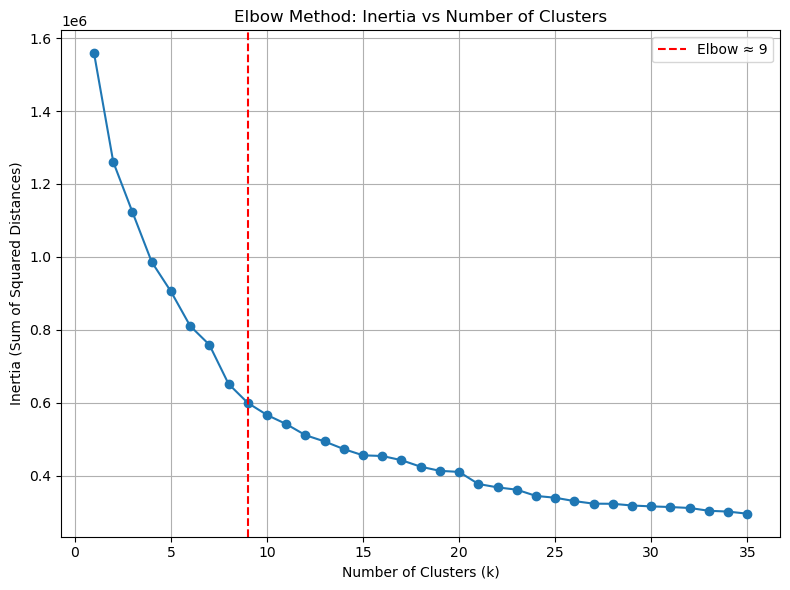

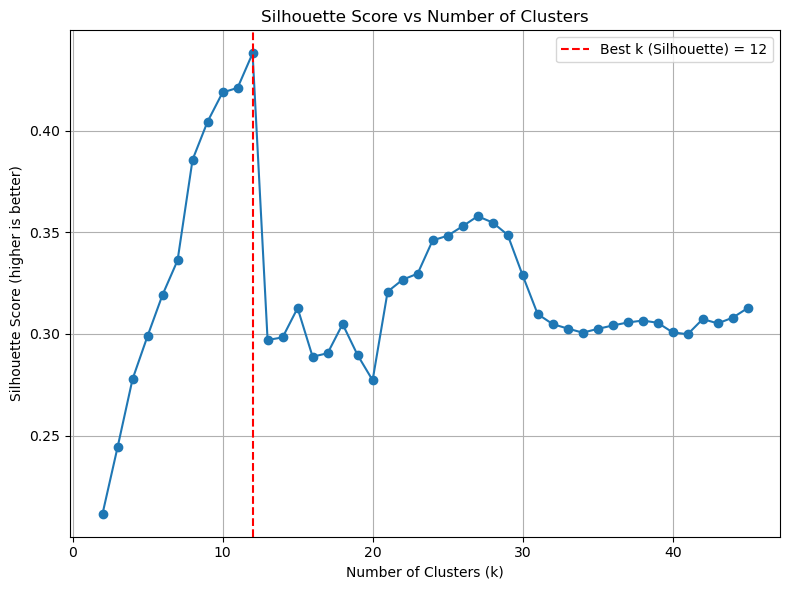

=== Summary ===
Elbow suggests k ≈ 9
Silhouette best k = 12, score = 0.4381

--- Comparison table (focused window) ---
 k   inertia silhouette
12 511738.71     0.4381
11 542068.14     0.4211
10 567030.16     0.4189
 9 600048.58     0.4045
 8 652061.43     0.3858
 7 759409.55     0.3362
14 473462.90     0.2983
13 494355.90     0.2970


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ---------- Helper: elbow knee by max distance ----------
def _knee_by_max_distance(ks, ys):
    """
    Robust elbow finder: max perpendicular distance to the line
    connecting the first and last points of (k, inertia).
    """
    x = np.array(ks, dtype=float)
    y = np.array(ys, dtype=float)
    x0, y0 = x[0], y[0]
    xN, yN = x[-1], y[-1]
    v = np.array([xN - x0, yN - y0])
    v_norm = np.linalg.norm(v)
    if v_norm == 0:
        return ks[0]
    distances = []
    for xi, yi in zip(x, y):
        w = np.array([xi - x0, yi - y0])
        cross = np.abs(np.cross(v, w))
        distances.append(cross / v_norm)
    return ks[int(np.argmax(distances))]

# ---------- Main routine ----------
def plot_elbow_and_silhouette(
    df_final,
    k_elbow_max=35,
    k_silhouette_max=45,
    random_state=42,
    n_init='auto',
    show_comparison=True,   # NEW: print a small comparison table
    comp_window=2,          # NEW: include ±comp_window around suggested ks
    sort_comparison_by='silhouette'  # or 'k' or 'inertia'
):
    """
    - Filters numeric columns, fills NaNs with 0, standardizes features.
    - Plots:
        1) Elbow: Inertia vs Number of Clusters (k = 1..k_elbow_max)
        2) Silhouette: Silhouette vs Number of Clusters (k = 2..k_silhouette_max)
    - Prints suggested ks and (optionally) a compact comparison table.
    - Returns a dict with all curves and a full (k, inertia, silhouette) DataFrame.
    """

    # 1) Ensure numeric, handle NaNs
    df_num = df_final.select_dtypes(include=['number']).fillna(0)
    if df_num.shape[1] == 0:
        raise ValueError("No numeric columns found in df_final.")
    n_samples = df_num.shape[0]
    if n_samples < 3:
        raise ValueError("Need at least 3 samples to run KMeans & silhouette reliably.")

    # 2) Standardize
    X = StandardScaler().fit_transform(df_num)

    # 3) Elbow (inertia)
    k_elbow_max = min(k_elbow_max, n_samples)
    k_range_elbow = list(range(1, k_elbow_max + 1))
    inertia_values = []
    for k in k_range_elbow:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        km.fit(X)
        inertia_values.append(km.inertia_)
    elbow_k = _knee_by_max_distance(k_range_elbow, inertia_values)

    # 4) Silhouette
    k_silhouette_max = min(k_silhouette_max, n_samples - 1)
    if k_silhouette_max < 2:
        raise ValueError("Not enough samples to compute silhouette (need k >= 2).")
    k_range_sil = list(range(2, k_silhouette_max + 1))
    sil_values = []
    for k in k_range_sil:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        labels = km.fit_predict(X)
        sil_values.append(silhouette_score(X, labels))
    best_k_sil = k_range_sil[int(np.argmax(sil_values))]

    # 5) Plot Elbow
    plt.figure(figsize=(8, 6))
    plt.plot(k_range_elbow, inertia_values, marker='o', linestyle='-')
    plt.axvline(elbow_k, color='r', linestyle='--', label=f'Elbow ≈ {elbow_k}')
    plt.title('Elbow Method: Inertia vs Number of Clusters')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Sum of Squared Distances)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 6) Plot Silhouette
    plt.figure(figsize=(8, 6))
    plt.plot(k_range_sil, sil_values, marker='o', linestyle='-')
    plt.axvline(best_k_sil, color='r', linestyle='--', label=f'Best k (Silhouette) = {best_k_sil}')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score (higher is better)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 7) Summary
    print("=== Summary ===")
    print(f"Elbow suggests k ≈ {elbow_k}")
    print(f"Silhouette best k = {best_k_sil}, score = {max(sil_values):.4f}")

    # 8) Build full comparison DataFrame (common k-range only)
    k_min_common = 2
    k_max_common = min(k_elbow_max, k_silhouette_max)
    ks_all = list(range(k_min_common, k_max_common + 1))

    # Map silhouette values by k for quick lookup
    sil_map = dict(zip(k_range_sil, sil_values))

    rows = []
    for k in ks_all:
        inertia_k = inertia_values[k - 1]  # k starts at 1, list at 0
        sil_k = sil_map.get(k, np.nan)
        rows.append({"k": k, "inertia": inertia_k, "silhouette": sil_k})
    df_compare_full = pd.DataFrame(rows)

    # 9) Print a small comparison table (focused around both suggested ks)
    if show_comparison:
        ks_focus = set([elbow_k, best_k_sil])
        for offset in range(-comp_window, comp_window + 1):
            ks_focus.add(max(k_min_common, min(k_max_common, elbow_k + offset)))
            ks_focus.add(max(k_min_common, min(k_max_common, best_k_sil + offset)))
        df_small = (
            df_compare_full[df_compare_full["k"].isin(sorted(ks_focus))]
            .sort_values(
                sort_comparison_by,
                ascending=(sort_comparison_by == "inertia")  # inertia: smaller is better
            )
        )
        # Nice printing
        print("\n--- Comparison table (focused window) ---")
        print(df_small.to_string(
            index=False,
            formatters={
                "inertia": lambda v: f"{v:.2f}",
                "silhouette": lambda v: "NaN" if pd.isna(v) else f"{v:.4f}",
            }
        ))

    # 10) Return everything for further use
    return {
        "elbow_k": elbow_k,
        "k_range_elbow": k_range_elbow,
        "inertia_values": inertia_values,
        "best_k_sil": best_k_sil,
        "k_range_sil": k_range_sil,
        "sil_values": sil_values,
        "df_compare_full": df_compare_full,  # complete table
    }

# ---------- Usage ----------
res = plot_elbow_and_silhouette(
    df_final,
    k_elbow_max=35,
    k_silhouette_max=45,
    show_comparison=True,   # prints small table
    comp_window=2,          # ±2 around elbow & silhouette k
    sort_comparison_by='silhouette'  # or 'k' or 'inertia'
)

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Extract numeric data and scale ---
df_num = df_final.select_dtypes(include=["number"]).fillna(0)
scaler = StandardScaler()
X = scaler.fit_transform(df_num)

# --- Choose optimal k (from silhouette) ---
optimal_k = res['best_k_sil']  # or res["elbow_k"]

# --- Fit KMeans ---
km = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
labels = km.fit_predict(X)

# --- Attach cluster labels back to DataFrame ---
df_final = df_final.copy()
df_final["Cluster"] = labels
print(df_final["Cluster"].value_counts())


Cluster
0     721
2     226
1     203
6     124
9     122
5     109
3      93
8      93
7      92
4      85
10     84
11     48
Name: count, dtype: int64


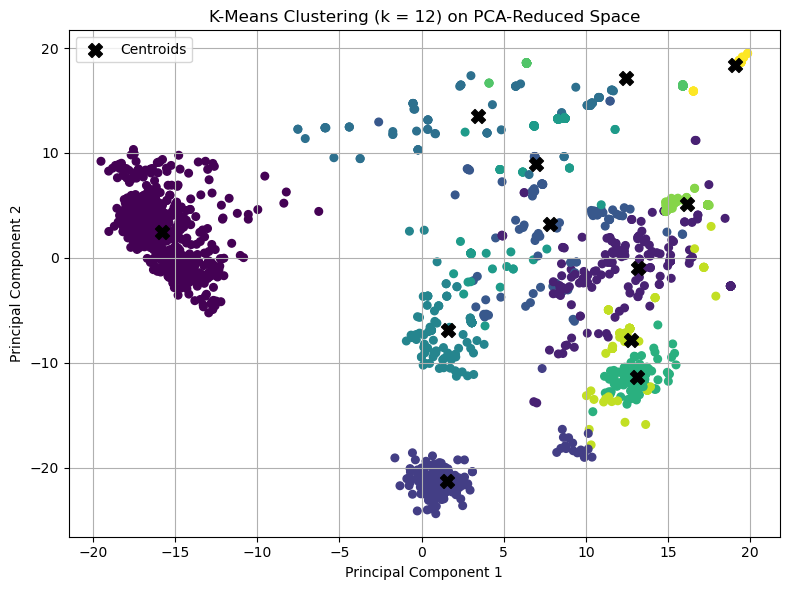

In [40]:
from sklearn.decomposition import PCA

# --- Reduce dimensions for visualisation ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# --- Plot clusters in 2-D ---
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=30)
plt.title(f"K-Means Clustering (k = {optimal_k}) on PCA-Reduced Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# --- Plot centroids (in PCA coordinates) ---
centroids_2d = pca.transform(km.cluster_centers_)
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1],
            c="black", marker="X", s=100, label="Centroids")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Compute centroid for each cluster
centroids = np.vstack([X_pca[labels == k].mean(axis=0) for k in range(optimal_k)])

# Distance of each point to its assigned cluster centroid
distances = np.zeros(X_pca.shape[0])
for k in range(optimal_k):
    cluster_mask = (labels == k)
    cluster_points = X_pca[cluster_mask]
    cluster_center = centroids[k]
    distances[cluster_mask] = np.linalg.norm(cluster_points - cluster_center, axis=1)

# Compute threshold for anomalies per cluster (mean + 2×std)
thresholds = {}
for k in range(optimal_k):
    d = distances[labels == k]
    thresholds[k] = np.mean(d) + 2 * np.std(d)

# Identify anomalies
anomaly_flags = np.zeros_like(distances, dtype=int)
for i in range(len(distances)):
    k = labels[i]
    if distances[i] > thresholds[k]:
        anomaly_flags[i] = 1

# Attach to DataFrame
df_final = df_final.copy()
df_final["DistanceToCentroid"] = distances
df_final["AnomalyFlag"] = anomaly_flags

# Summary
n_anomalies = np.sum(anomaly_flags)
print(f"Detected {n_anomalies} anomalies out of {len(df_final)} samples.")


Detected 104 anomalies out of 2000 samples.


In [50]:
df_final["AnomalyFlag"].value_counts()


AnomalyFlag
0    1896
1     104
Name: count, dtype: int64

In [52]:
y.value_counts()

Label
0    1857
1     143
Name: count, dtype: int64

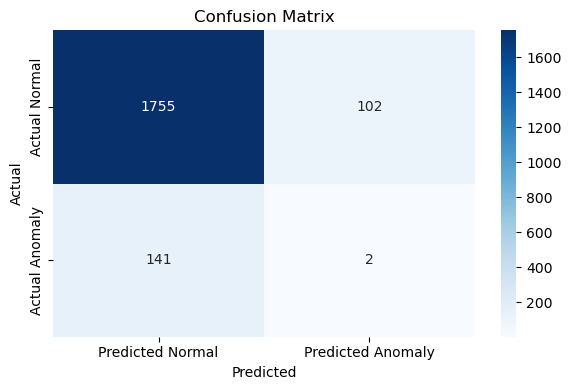

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Replace this with your actual ground truth labels
# Example: y = df_final['TrueLabel'] or y = pd.Series([...])
# Ensure y is defined and matches df_final['AnomalyFlag'] in length

# Compute confusion matrix
cm = confusion_matrix(y, df_final['AnomalyFlag'])

# Create a labeled DataFrame
cm_df = pd.DataFrame(cm, index=['Actual Normal', 'Actual Anomaly'],
                         columns=['Predicted Normal', 'Predicted Anomaly'])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


=== Anomaly Detection Summary ===
           Model  Anomalies Rate(%)
          KMeans         79   3.95%
 IsolationForest        140   7.00%
             LOF        112   5.60%
     OneClassSVM        141   7.05%
EllipticEnvelope        100   5.00%


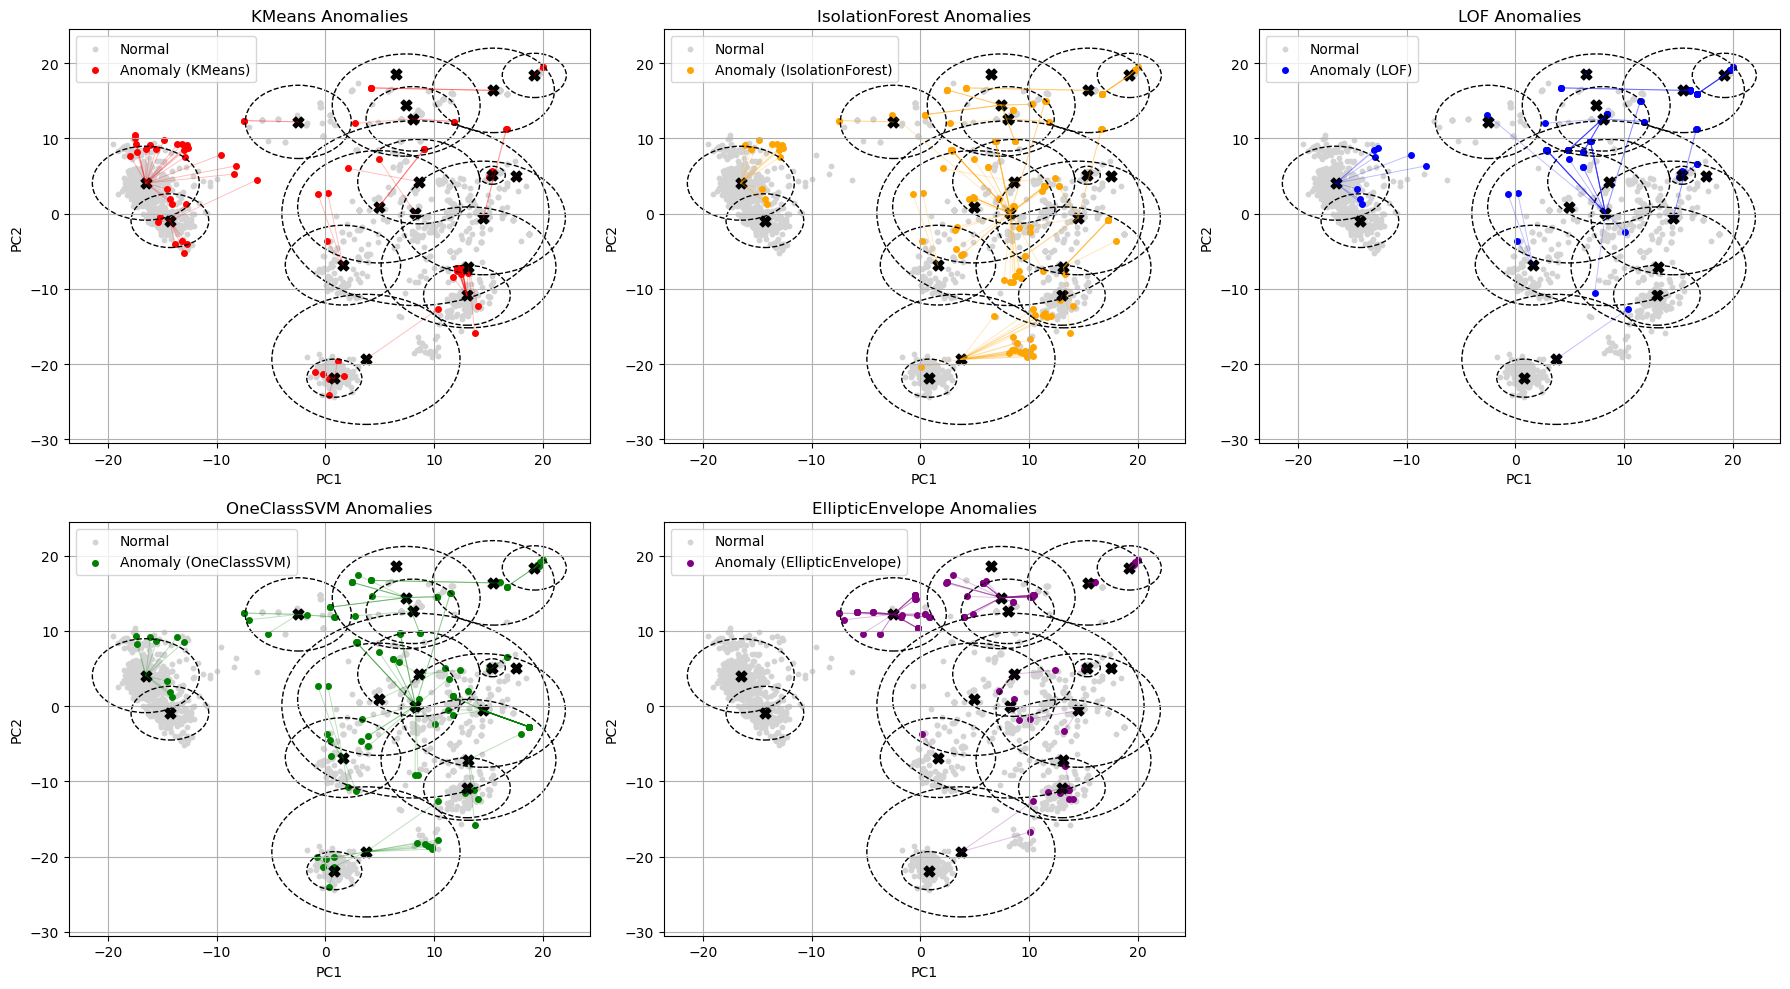

In [17]:
# -*- coding: utf-8 -*-
# Multi-Model Unsupervised Anomaly Detection with Cluster Visualization
# Models: KMeans Distance, Isolation Forest, LOF, One-Class SVM, Elliptic Envelope

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

# ---------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------
k_value = 19           # 🔧 manually set the number of clusters
USE_PCA = True         # set False to run without PCA
PCA_VARIANCE = 0.95
RANDOM_STATE = 42
N_INIT = 'auto'

# Model parameters
LOF_NEIGHBORS = 35
IF_ESTIMATORS = 500
SVM_NU = 0.05
EE_CONTAM = 0.05

# ---------------------------------------------------------
# 1️⃣ Data Preparation
# ---------------------------------------------------------
df_num = df_final.select_dtypes(include=['number']).fillna(0)
if df_num.shape[0] < 5 or df_num.shape[1] == 0:
    raise ValueError("Data must contain numeric columns and at least 5 rows.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

if USE_PCA:
    pca = PCA(n_components=PCA_VARIANCE, random_state=RANDOM_STATE)
    X = pca.fit_transform(X_scaled)
else:
    X = X_scaled

n_samples = X.shape[0]

# ---------------------------------------------------------
# 2️⃣ KMeans Clustering + Distance-Based Anomalies
# ---------------------------------------------------------
km = KMeans(n_clusters=k_value, random_state=RANDOM_STATE, n_init=N_INIT)
labels = km.fit_predict(X)

# Compute centroids and distances
centroids = np.vstack([X[labels == k].mean(axis=0) for k in range(k_value)])
distances = np.zeros(n_samples)
for k in range(k_value):
    mask = (labels == k)
    cluster_points = X[mask]
    cluster_center = centroids[k]
    distances[mask] = np.linalg.norm(cluster_points - cluster_center, axis=1)

# Threshold per cluster (mean + 2×std)
thresholds = {}
for k in range(k_value):
    d = distances[labels == k]
    thresholds[k] = np.mean(d) + 2 * np.std(d)

km_anom = np.zeros_like(distances, dtype=int)
for i in range(n_samples):
    k = labels[i]
    if distances[i] > thresholds[k]:
        km_anom[i] = 1

# ---------------------------------------------------------
# 3️⃣ Isolation Forest
# ---------------------------------------------------------
iso = IsolationForest(
    n_estimators=IF_ESTIMATORS,
    contamination=0.07,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
iso.fit(X)
if_pred = iso.predict(X)      # 1=normal, -1=anomaly
if_anom = (if_pred == -1).astype(int)

# ---------------------------------------------------------
# 4️⃣ LOF
# ---------------------------------------------------------
lof = LocalOutlierFactor(
    n_neighbors=LOF_NEIGHBORS,
    contamination="auto",
    novelty=False,
    n_jobs=-1
)
lof_pred = lof.fit_predict(X)
lof_anom = (lof_pred == -1).astype(int)

# ---------------------------------------------------------
# 5️⃣ One-Class SVM
# ---------------------------------------------------------
ocsvm = OneClassSVM(kernel='rbf', nu=SVM_NU, gamma='scale')
ocsvm.fit(X)
svm_pred = ocsvm.predict(X)   # 1=normal, -1=anomaly
svm_anom = (svm_pred == -1).astype(int)

# ---------------------------------------------------------
# 6️⃣ Elliptic Envelope
# ---------------------------------------------------------
ee = EllipticEnvelope(contamination=EE_CONTAM, random_state=RANDOM_STATE)
ee.fit(X)
ee_pred = ee.predict(X)       # 1=normal, -1=anomaly
ee_anom = (ee_pred == -1).astype(int)

# ---------------------------------------------------------
# 7️⃣ Combine Results
# ---------------------------------------------------------
out = df_final.copy()
out["KM_Cluster"] = labels
out["KM_Anom"] = km_anom
out["IF_Anom"] = if_anom
out["LOF_Anom"] = lof_anom
out["SVM_Anom"] = svm_anom
out["EE_Anom"] = ee_anom
out["KM_Dist"] = distances

# Optional: keep first two PCs for visualization
if USE_PCA:
    X2 = X[:, :2]
    out["PC1"] = X2[:, 0]
    out["PC2"] = X2[:, 1]
else:
    pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca_vis.fit_transform(X)
    out["PC1"] = X2[:, 0]
    out["PC2"] = X2[:, 1]

# ---------------------------------------------------------
# 8️⃣ Print Summary of Anomalies
# ---------------------------------------------------------
n = len(out)
summary = pd.DataFrame({
    "Model": ["KMeans", "IsolationForest", "LOF", "OneClassSVM", "EllipticEnvelope"],
    "Anomalies": [
        out["KM_Anom"].sum(),
        out["IF_Anom"].sum(),
        out["LOF_Anom"].sum(),
        out["SVM_Anom"].sum(),
        out["EE_Anom"].sum()
    ]
})
summary["Rate(%)"] = 100.0 * summary["Anomalies"] / n
print("\n=== Anomaly Detection Summary ===")
print(summary.to_string(index=False, formatters={"Rate(%)": lambda x: f"{x:.2f}%"}))

# ---------------------------------------------------------
# 9️⃣ Visualization — Centroid Circles + Lines to Anomalies
# ---------------------------------------------------------
centroids_2d = np.vstack([X2[labels == k].mean(axis=0) for k in range(k_value)])

# radius (mean + 2*std) in 2D space for visualization
radius_2d = {}
for k in range(k_value):
    mask = (labels == k)
    d = np.linalg.norm(X2[mask] - centroids_2d[k], axis=1)
    radius_2d[k] = np.mean(d) + 2 * np.std(d)

# Models to visualize
models = [
    ("KMeans", "KM_Anom", "red"),
    ("IsolationForest", "IF_Anom", "orange"),
    ("LOF", "LOF_Anom", "blue"),
    ("OneClassSVM", "SVM_Anom", "green"),
    ("EllipticEnvelope", "EE_Anom", "purple")
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, (title, col, color) in enumerate(models):
    ax = axes[i]
    mask_norm = (out[col] == 0)
    mask_anom = (out[col] == 1)

    # Scatter normal vs anomaly
    ax.scatter(X2[mask_norm, 0], X2[mask_norm, 1], c="lightgray", s=10, label="Normal")
    ax.scatter(X2[mask_anom, 0], X2[mask_anom, 1], c=color, s=16, label=f"Anomaly ({title})")

    # Draw centroids, circles, and rays to anomalies
    for k in range(k_value):
        cx, cy = centroids_2d[k]
        ax.scatter([cx], [cy], c="black", marker="X", s=60)
        circle = Circle((cx, cy), radius_2d[k], fill=False, color="black", linestyle="--", linewidth=1)
        ax.add_patch(circle)
        idx_anom = np.where((labels == k) & (out[col] == 1))[0]
        for j in idx_anom:
            ax.plot([cx, X2[j, 0]], [cy, X2[j, 1]], color=color, alpha=0.25, linewidth=0.7)

    ax.set_title(f"{title} Anomalies")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True)
    ax.legend(loc="best")

# Hide empty subplot if odd count
if len(models) < len(axes):
    for j in range(len(models), len(axes)):
        axes[j].axis("off")

plt.tight_layout()
plt.show()



=== Anomaly Detection Summary ===
           Model  Anomalies Rate(%)
          KMeans         79   3.95%
 IsolationForest        107   5.35%
             LOF        112   5.60%
     OneClassSVM        141   7.05%
EllipticEnvelope        100   5.00%


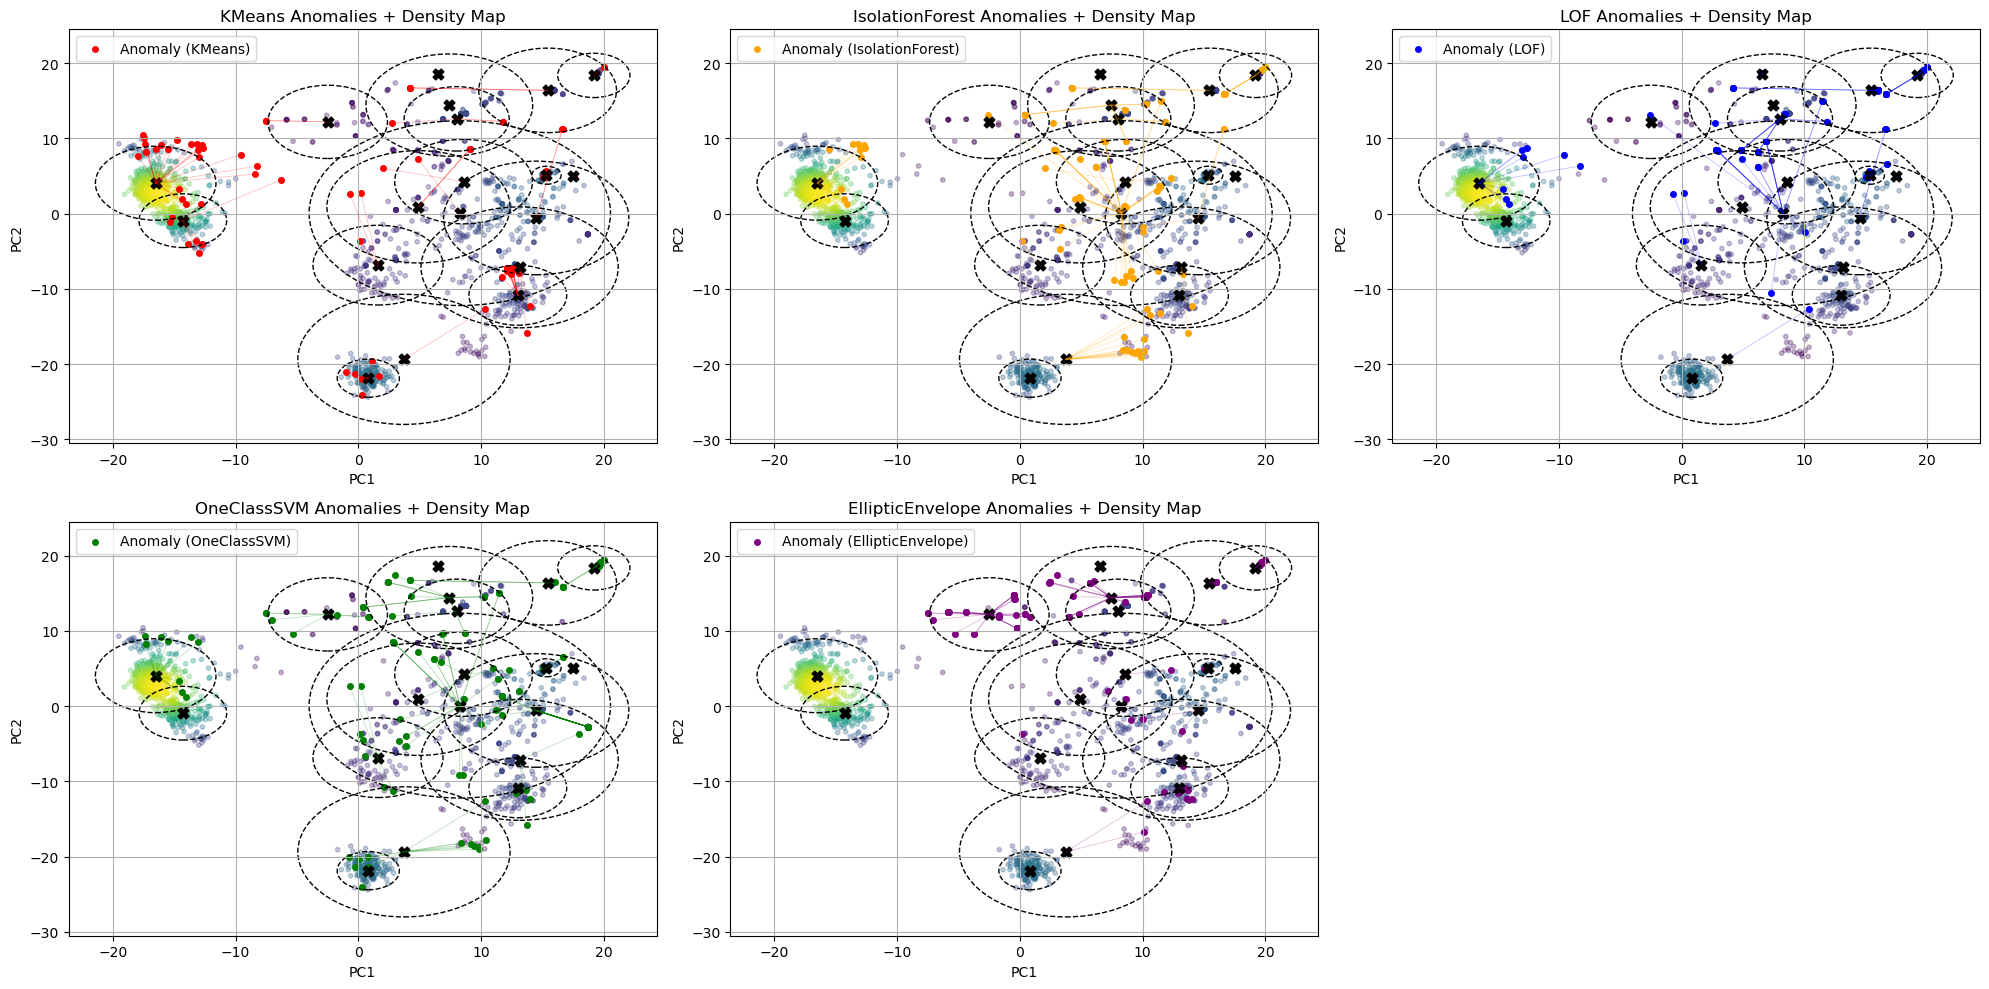

In [18]:
# -*- coding: utf-8 -*-
# Multi-Model Unsupervised Anomaly Detection + Density Visualization
# Models: KMeans Distance, Isolation Forest, LOF, One-Class SVM, Elliptic Envelope

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from scipy.stats import gaussian_kde

# ---------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------
k_value = 19           # manually set cluster count
USE_PCA = True
PCA_VARIANCE = 0.95
RANDOM_STATE = 42
N_INIT = 'auto'

# Model parameters
LOF_NEIGHBORS = 35
IF_ESTIMATORS = 500
SVM_NU = 0.05
EE_CONTAM = 0.05

# ---------------------------------------------------------
# 1️⃣ Data Preparation
# ---------------------------------------------------------
df_num = df_final.select_dtypes(include=['number']).fillna(0)
if df_num.shape[0] < 5 or df_num.shape[1] == 0:
    raise ValueError("Data must have numeric columns and at least 5 rows.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

if USE_PCA:
    pca = PCA(n_components=PCA_VARIANCE, random_state=RANDOM_STATE)
    X = pca.fit_transform(X_scaled)
else:
    X = X_scaled

n_samples = X.shape[0]

# ---------------------------------------------------------
# 2️⃣ KMeans Clustering + Distance-Based Anomalies
# ---------------------------------------------------------
km = KMeans(n_clusters=k_value, random_state=RANDOM_STATE, n_init=N_INIT)
labels = km.fit_predict(X)

centroids = np.vstack([X[labels == k].mean(axis=0) for k in range(k_value)])
distances = np.zeros(n_samples)
for k in range(k_value):
    mask = (labels == k)
    cluster_points = X[mask]
    cluster_center = centroids[k]
    distances[mask] = np.linalg.norm(cluster_points - cluster_center, axis=1)

thresholds = {}
for k in range(k_value):
    d = distances[labels == k]
    thresholds[k] = np.mean(d) + 2 * np.std(d)

km_anom = np.zeros_like(distances, dtype=int)
for i in range(n_samples):
    k = labels[i]
    if distances[i] > thresholds[k]:
        km_anom[i] = 1

# ---------------------------------------------------------
# 3️⃣ Isolation Forest
# ---------------------------------------------------------
iso = IsolationForest(
    n_estimators=IF_ESTIMATORS,
    contamination="auto",
    random_state=RANDOM_STATE,
    n_jobs=-1
)
iso.fit(X)
if_pred = iso.predict(X)
if_anom = (if_pred == -1).astype(int)

# ---------------------------------------------------------
# 4️⃣ LOF
# ---------------------------------------------------------
lof = LocalOutlierFactor(
    n_neighbors=LOF_NEIGHBORS,
    contamination="auto",
    novelty=False,
    n_jobs=-1
)
lof_pred = lof.fit_predict(X)
lof_anom = (lof_pred == -1).astype(int)

# ---------------------------------------------------------
# 5️⃣ One-Class SVM
# ---------------------------------------------------------
ocsvm = OneClassSVM(kernel='rbf', nu=SVM_NU, gamma='scale')
ocsvm.fit(X)
svm_pred = ocsvm.predict(X)
svm_anom = (svm_pred == -1).astype(int)

# ---------------------------------------------------------
# 6️⃣ Elliptic Envelope
# ---------------------------------------------------------
ee = EllipticEnvelope(contamination=EE_CONTAM, random_state=RANDOM_STATE)
ee.fit(X)
ee_pred = ee.predict(X)
ee_anom = (ee_pred == -1).astype(int)

# ---------------------------------------------------------
# 7️⃣ Combine Results
# ---------------------------------------------------------
out = df_final.copy()
out["KM_Cluster"] = labels
out["KM_Anom"] = km_anom
out["IF_Anom"] = if_anom
out["LOF_Anom"] = lof_anom
out["SVM_Anom"] = svm_anom
out["EE_Anom"] = ee_anom
out["KM_Dist"] = distances

# Prepare PCA 2D projection for plotting
if USE_PCA:
    X2 = X[:, :2]
else:
    pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca_vis.fit_transform(X)
out["PC1"] = X2[:, 0]
out["PC2"] = X2[:, 1]

# ---------------------------------------------------------
# 8️⃣ Anomaly Summary
# ---------------------------------------------------------
n = len(out)
summary = pd.DataFrame({
    "Model": ["KMeans", "IsolationForest", "LOF", "OneClassSVM", "EllipticEnvelope"],
    "Anomalies": [
        out["KM_Anom"].sum(),
        out["IF_Anom"].sum(),
        out["LOF_Anom"].sum(),
        out["SVM_Anom"].sum(),
        out["EE_Anom"].sum()
    ]
})
summary["Rate(%)"] = 100.0 * summary["Anomalies"] / n
print("\n=== Anomaly Detection Summary ===")
print(summary.to_string(index=False, formatters={"Rate(%)": lambda x: f"{x:.2f}%"}))

# ---------------------------------------------------------
# 9️⃣ Visualization — Clusters, Circles, and Anomalies
# ---------------------------------------------------------
centroids_2d = np.vstack([X2[labels == k].mean(axis=0) for k in range(k_value)])

radius_2d = {}
for k in range(k_value):
    mask = (labels == k)
    d = np.linalg.norm(X2[mask] - centroids_2d[k], axis=1)
    radius_2d[k] = np.mean(d) + 2 * np.std(d)

models = [
    ("KMeans", "KM_Anom", "red"),
    ("IsolationForest", "IF_Anom", "orange"),
    ("LOF", "LOF_Anom", "blue"),
    ("OneClassSVM", "SVM_Anom", "green"),
    ("EllipticEnvelope", "EE_Anom", "purple")
]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.ravel()

for i, (title, col, color) in enumerate(models):
    ax = axes[i]
    mask_norm = (out[col] == 0)
    mask_anom = (out[col] == 1)

    # Density map
    xy = np.vstack([X2[:, 0], X2[:, 1]])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    X2_sorted, z_sorted = X2[idx], z[idx]
    ax.scatter(X2_sorted[:, 0], X2_sorted[:, 1], c=z_sorted, s=10, cmap="viridis", alpha=0.3)

    # Overlay anomalies
    ax.scatter(X2[mask_anom, 0], X2[mask_anom, 1], c=color, s=16, label=f"Anomaly ({title})")

    # Draw centroids and circles
    for k in range(k_value):
        cx, cy = centroids_2d[k]
        ax.scatter([cx], [cy], c="black", marker="X", s=60)
        circ = Circle((cx, cy), radius_2d[k], fill=False, edgecolor="black", linestyle="--", linewidth=1)
        ax.add_patch(circ)

        # Rays to anomalies
        idx_anom = np.where((labels == k) & (out[col] == 1))[0]
        for j in idx_anom:
            ax.plot([cx, X2[j, 0]], [cy, X2[j, 1]], color=color, alpha=0.25, linewidth=0.6)

    ax.set_title(f"{title} Anomalies + Density Map")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True)
    ax.legend(loc="best")

if len(models) < len(axes):
    for j in range(len(models), len(axes)):
        axes[j].axis("off")

plt.tight_layout()
plt.show()


In [19]:
# -*- coding: utf-8 -*-
# Final Multi-Model Unsupervised Anomaly Detection + Interactive 3D Visualization
# Models: KMeans Distance, Isolation Forest, LOF, One-Class SVM, Elliptic Envelope

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

# ---------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------
k_value = 19
USE_PCA = True
PCA_VARIANCE = 0.99
RANDOM_STATE = 42
N_INIT = 'auto'

LOF_NEIGHBORS = 35
IF_ESTIMATORS = 500
SVM_NU = 0.05
EE_CONTAM = 0.05

# ---------------------------------------------------------
# 1️⃣ Data Preparation
# ---------------------------------------------------------
df_num = df_final.select_dtypes(include=['number']).fillna(0)
if df_num.shape[0] < 5 or df_num.shape[1] == 0:
    raise ValueError("Data must contain numeric columns and at least 5 rows.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

if USE_PCA:
    pca = PCA(n_components=PCA_VARIANCE, random_state=RANDOM_STATE)
    X = pca.fit_transform(X_scaled)
else:
    X = X_scaled

n_samples = X.shape[0]

# ---------------------------------------------------------
# 2️⃣ KMeans Clustering + Distance-Based Anomalies
# ---------------------------------------------------------
km = KMeans(n_clusters=k_value, random_state=RANDOM_STATE, n_init=N_INIT)
labels = km.fit_predict(X)

centroids = np.vstack([X[labels == k].mean(axis=0) for k in range(k_value)])
distances = np.zeros(n_samples)
for k in range(k_value):
    mask = (labels == k)
    cluster_points = X[mask]
    cluster_center = centroids[k]
    distances[mask] = np.linalg.norm(cluster_points - cluster_center, axis=1)

thresholds = {k: np.mean(distances[labels == k]) + 2*np.std(distances[labels == k]) for k in range(k_value)}
km_anom = np.array([1 if distances[i] > thresholds[labels[i]] else 0 for i in range(n_samples)])

# ---------------------------------------------------------
# 3️⃣ Isolation Forest
# ---------------------------------------------------------
iso = IsolationForest(n_estimators=IF_ESTIMATORS, contamination="auto", random_state=RANDOM_STATE)
iso.fit(X)
if_pred = iso.predict(X)
if_anom = (if_pred == -1).astype(int)

# ---------------------------------------------------------
# 4️⃣ LOF
# ---------------------------------------------------------
lof = LocalOutlierFactor(n_neighbors=LOF_NEIGHBORS, contamination="auto", novelty=False)
lof_pred = lof.fit_predict(X)
lof_anom = (lof_pred == -1).astype(int)

# ---------------------------------------------------------
# 5️⃣ One-Class SVM
# ---------------------------------------------------------
ocsvm = OneClassSVM(kernel='rbf', nu=SVM_NU, gamma='scale')
ocsvm.fit(X)
svm_pred = ocsvm.predict(X)
svm_anom = (svm_pred == -1).astype(int)

# ---------------------------------------------------------
# 6️⃣ Elliptic Envelope
# ---------------------------------------------------------
ee = EllipticEnvelope(contamination=EE_CONTAM, random_state=RANDOM_STATE)
ee.fit(X)
ee_pred = ee.predict(X)
ee_anom = (ee_pred == -1).astype(int)

# ---------------------------------------------------------
# 7️⃣ Combine Results
# ---------------------------------------------------------
out = df_final.copy()
out["KM_Cluster"] = labels
out["KM_Anom"] = km_anom
out["IF_Anom"] = if_anom
out["LOF_Anom"] = lof_anom
out["SVM_Anom"] = svm_anom
out["EE_Anom"] = ee_anom
out["KM_Dist"] = distances

# ---------------------------------------------------------
# 8️⃣ Fit New PCA (3 Components) for Interactive 3D Visualization
# ---------------------------------------------------------
# ✅ FIXED: Fit on the same feature space (X) used by the models
pca3 = PCA(n_components=3, random_state=RANDOM_STATE)
X3 = pca3.fit_transform(X)
out["PC1"], out["PC2"], out["PC3"] = X3[:, 0], X3[:, 1], X3[:, 2]

# Project centroids to same 3D PCA space
centroid3d = pca3.transform(centroids)

# ---------------------------------------------------------
# 9️⃣ Summary
# ---------------------------------------------------------
summary = pd.DataFrame({
    "Model": ["KMeans", "IsolationForest", "LOF", "OneClassSVM", "EllipticEnvelope"],
    "Anomalies": [
        out["KM_Anom"].sum(),
        out["IF_Anom"].sum(),
        out["LOF_Anom"].sum(),
        out["SVM_Anom"].sum(),
        out["EE_Anom"].sum()
    ]
})
summary["Rate(%)"] = 100 * summary["Anomalies"] / len(out)
print("\n=== Anomaly Detection Summary ===")
print(summary.to_string(index=False, formatters={"Rate(%)": lambda x: f"{x:.2f}%"}))

# ---------------------------------------------------------
# 🔟 Interactive 3D Visualization (Plotly)
# ---------------------------------------------------------
def plot_3d_anomalies(model_name, flag_col, color):
    fig = go.Figure()

    # Normal points
    df_norm = out[out[flag_col] == 0]
    fig.add_trace(go.Scatter3d(
        x=df_norm["PC1"], y=df_norm["PC2"], z=df_norm["PC3"],
        mode="markers",
        marker=dict(size=3, color="lightgray", opacity=0.5),
        name="Normal"
    ))

    # Anomalies
    df_anom = out[out[flag_col] == 1]
    fig.add_trace(go.Scatter3d(
        x=df_anom["PC1"], y=df_anom["PC2"], z=df_anom["PC3"],
        mode="markers",
        marker=dict(size=4, color=color, opacity=0.9, symbol="diamond"),
        name=f"Anomalies ({model_name})"
    ))

    # Centroids (KMeans)
    fig.add_trace(go.Scatter3d(
        x=centroid3d[:, 0], y=centroid3d[:, 1], z=centroid3d[:, 2],
        mode="markers+text",
        marker=dict(size=8, color="black", symbol="x"),
        name="Centroids",
        text=[f"C{k}" for k in range(k_value)],
        textposition="top center"
    ))

    # Layout
    fig.update_layout(
        title=f"3D PCA — {model_name} Anomaly Visualization (k={k_value})",
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3"
        ),
        width=900,
        height=700,
        template="plotly_white",
        legend=dict(itemsizing="constant")
    )

    fig.show()


# ---------------------------------------------------------
# 1️⃣1️⃣ Generate Interactive Plots for All Models
# ---------------------------------------------------------
plot_3d_anomalies("KMeans", "KM_Anom", "red")
plot_3d_anomalies("Isolation Forest", "IF_Anom", "orange")
plot_3d_anomalies("LOF", "LOF_Anom", "blue")
plot_3d_anomalies("One-Class SVM", "SVM_Anom", "green")
plot_3d_anomalies("Elliptic Envelope", "EE_Anom", "purple")



=== Anomaly Detection Summary ===
           Model  Anomalies Rate(%)
          KMeans         83   4.15%
 IsolationForest         47   2.35%
             LOF        117   5.85%
     OneClassSVM        104   5.20%
EllipticEnvelope        100   5.00%


In [20]:
# Make "y" binary: 0 for normal ("-"), 1 for anomaly (everything else)
y = (df["Label"].astype(str).str.strip() != "-").astype(int)

y

0       0
1       0
2       0
3       0
4       0
       ..
1995    0
1996    0
1997    0
1998    0
1999    0
Name: Label, Length: 2000, dtype: int64

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# ----------------------------
# Make "y" binary: 0 for normal ("-"), 1 for anomaly (everything else)
y = (df["Label"].astype(str).str.strip() != "-").astype(int)

# Quick sanity check on class balance
print("Class balance:")
print(y.value_counts())
print(y.value_counts(normalize=True).rename({0: "normal", 1: "anomaly"}))


Class balance:
Label
0    1857
1     143
Name: count, dtype: int64
Label
normal     0.9285
anomaly    0.0715
Name: proportion, dtype: float64


Class balance:
Label
0    1857
1     143
Name: count, dtype: int64
Label
normal     0.9285
anomaly    0.0715
Name: proportion, dtype: float64


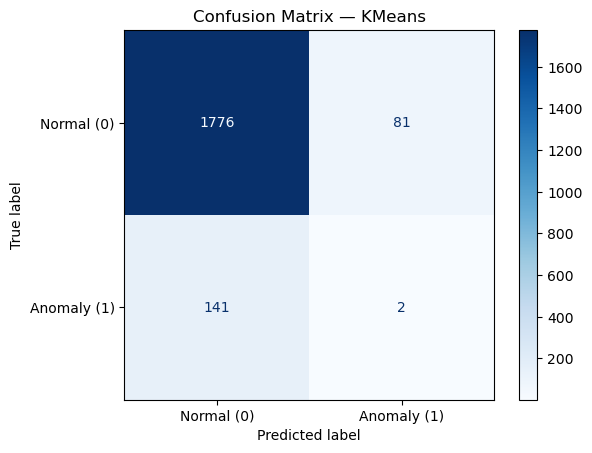


=== KMeans Classification Report ===
              precision    recall  f1-score   support

      Normal       0.93      0.96      0.94      1857
     Anomaly       0.02      0.01      0.02       143

    accuracy                           0.89      2000
   macro avg       0.48      0.49      0.48      2000
weighted avg       0.86      0.89      0.88      2000



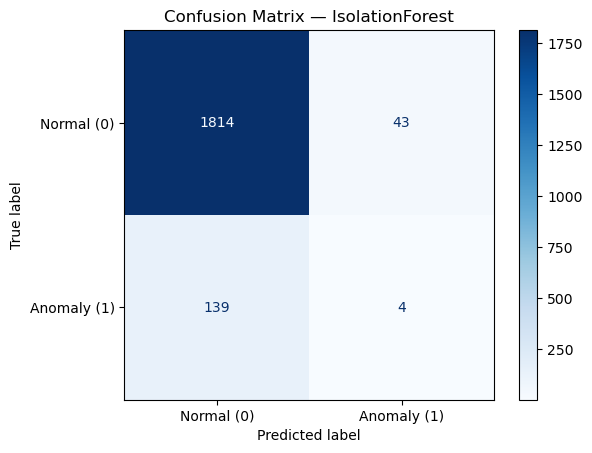


=== IsolationForest Classification Report ===
              precision    recall  f1-score   support

      Normal       0.93      0.98      0.95      1857
     Anomaly       0.09      0.03      0.04       143

    accuracy                           0.91      2000
   macro avg       0.51      0.50      0.50      2000
weighted avg       0.87      0.91      0.89      2000



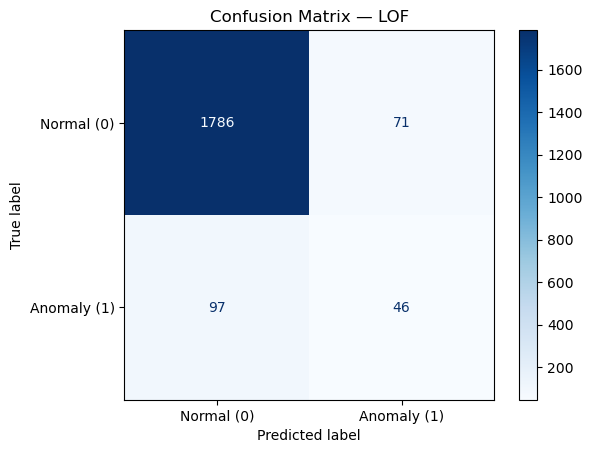


=== LOF Classification Report ===
              precision    recall  f1-score   support

      Normal       0.95      0.96      0.96      1857
     Anomaly       0.39      0.32      0.35       143

    accuracy                           0.92      2000
   macro avg       0.67      0.64      0.65      2000
weighted avg       0.91      0.92      0.91      2000



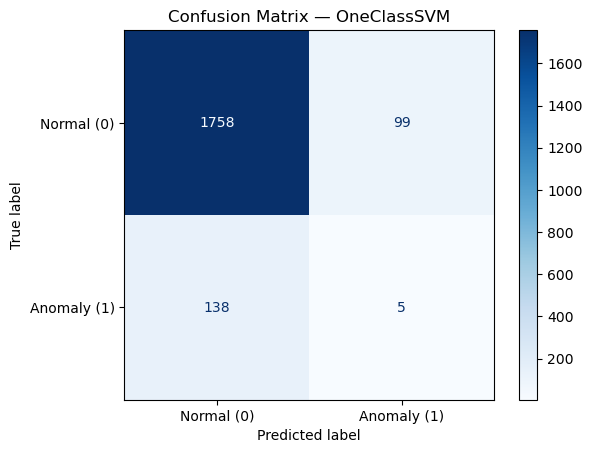


=== OneClassSVM Classification Report ===
              precision    recall  f1-score   support

      Normal       0.93      0.95      0.94      1857
     Anomaly       0.05      0.03      0.04       143

    accuracy                           0.88      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.86      0.88      0.87      2000



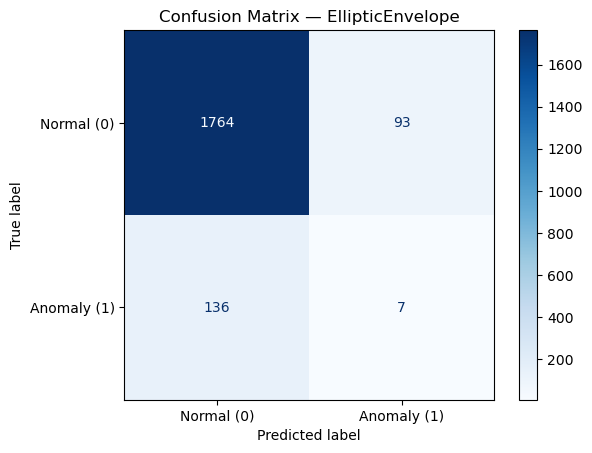


=== EllipticEnvelope Classification Report ===
              precision    recall  f1-score   support

      Normal       0.93      0.95      0.94      1857
     Anomaly       0.07      0.05      0.06       143

    accuracy                           0.89      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.87      0.89      0.88      2000



In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# ----------------------------
# Make "y" binary: 0 for normal ("-"), 1 for anomaly (everything else)
y = (df["Label"].astype(str).str.strip() != "-").astype(int)

# Quick sanity check on class balance
print("Class balance:")
print(y.value_counts())
print(y.value_counts(normalize=True).rename({0: "normal", 1: "anomaly"}))

# ----------------------------
# Model predictions
# ----------------------------
preds = {
    "KMeans": out["KM_Anom"],
    "IsolationForest": out["IF_Anom"],
    "LOF": out["LOF_Anom"],
    "OneClassSVM": out["SVM_Anom"],
    "EllipticEnvelope": out["EE_Anom"]
}

# ----------------------------
# Ensure KMeans anomaly flags are properly thresholded (0/1)
# KMeans anomaly flagging uses distance-to-centroid
# We explicitly ensure the anomalies are set to 1, and normals to 0
# out["KM_Anom"] = (out["KM_Dist"] > out["KM_Dist"].mean() + 2 * out["KM_Dist"].std()).astype(int)
out["KM_Anom"] = (out["KM_Dist"] > out["KM_Dist"].mean() + 2 * out["KM_Dist"].std()).astype(int)

# ----------------------------
# Compute and plot confusion matrices
# ----------------------------
for name, y_pred in preds.items():
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Anomaly (1)"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

    # Optional: detailed metrics (precision, recall, f1-score)
    print(f"\n=== {name} Classification Report ===")
    print(classification_report(y, y_pred, target_names=["Normal", "Anomaly"]))


In [22]:
# Inspect the distribution of true labels (y) and predicted anomalies for KMeans (KM_Anom)
print("True label distribution (y):")
print(pd.Series(y).value_counts())

print("\nPredicted anomalies for KMeans (KM_Anom):")
print(pd.Series(out["KM_Anom"]).value_counts())


True label distribution (y):
Label
0    1857
1     143
Name: count, dtype: int64

Predicted anomalies for KMeans (KM_Anom):
KM_Anom
0    1918
1      82
Name: count, dtype: int64


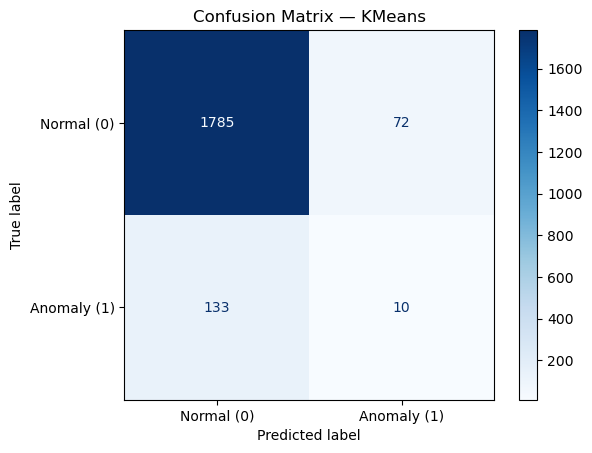


=== KMeans Classification Report ===
              precision    recall  f1-score   support

      Normal       0.93      0.96      0.95      1857
     Anomaly       0.12      0.07      0.09       143

    accuracy                           0.90      2000
   macro avg       0.53      0.52      0.52      2000
weighted avg       0.87      0.90      0.88      2000



In [23]:
# Recompute and plot confusion matrix
cm = confusion_matrix(y, out["KM_Anom"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Anomaly (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — KMeans")
plt.show()

# Detailed metrics for KMeans
print(f"\n=== KMeans Classification Report ===")
print(classification_report(y, out["KM_Anom"], target_names=["Normal", "Anomaly"]))
